 # Assignment 3

In [2]:
import pandas as pd
import sklearn
import numpy
import surprise
import matplotlib
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import Dataset

## Data processing

All genres:  {'Adventure', 'Fantasy', 'Western', 'Drama', 'Sci-Fi', 'Romance', 'Mystery', 'Film-Noir', 'Comedy', '(no genres listed)', 'Crime', 'Animation', 'Thriller', 'War', 'IMAX', 'Action', 'Documentary', 'Children', 'Musical', 'Horror'}
Amount of ratings:  97801
Amount of users:  600
Amount of movies:  9680
Amount of movies that are rated before release:  3
Interval of dataset:  1996-03-29 18:36:55 - 2018-09-24 14:27:30
Rating counts:  rating
0.5     1329
1.0     2735
1.5     1714
2.0     7366
2.5     5261
3.0    19560
3.5    12586
4.0    26074
4.5     8232
5.0    12944
Name: count, dtype: int64
Date counts:  release_year
1902       5
1903       2
1908       1
1915       1
1916       5
        ... 
2014    1313
2015    1088
2016     787
2017     460
2018     104
Name: count, Length: 106, dtype: int64
Ratings per user counts:  19       1
20      16
21      12
22      14
23      12
        ..
1346     1
1863     1
2108     1
2477     1
2698     1
Name: count, Length: 258, dtype: int

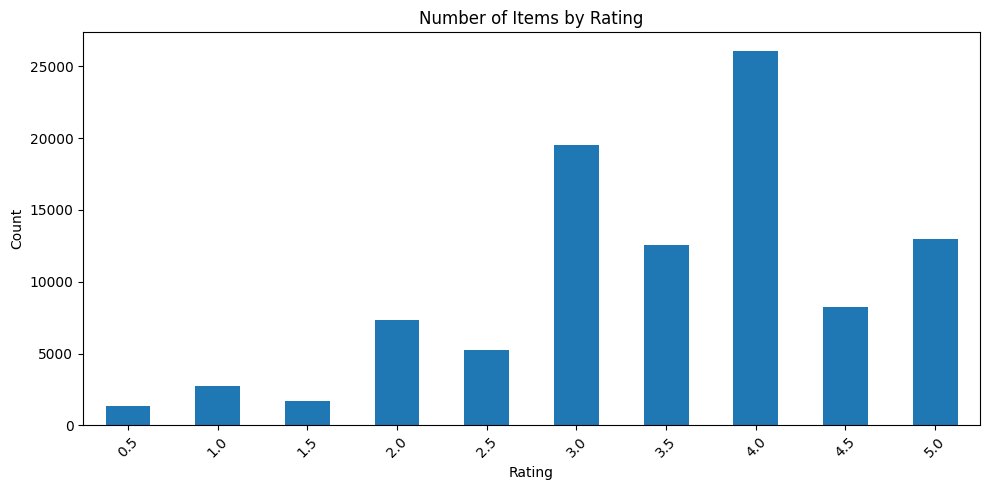

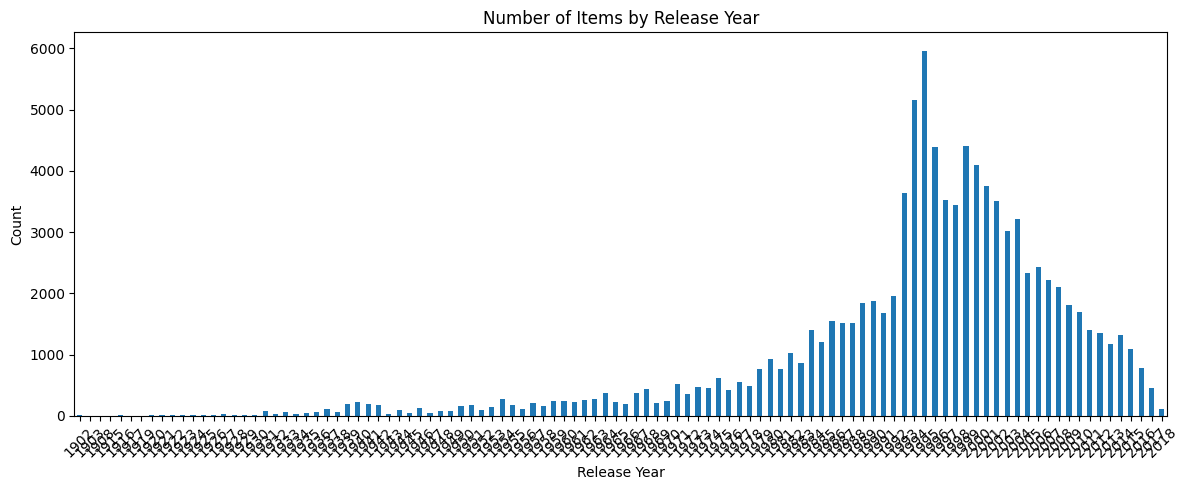

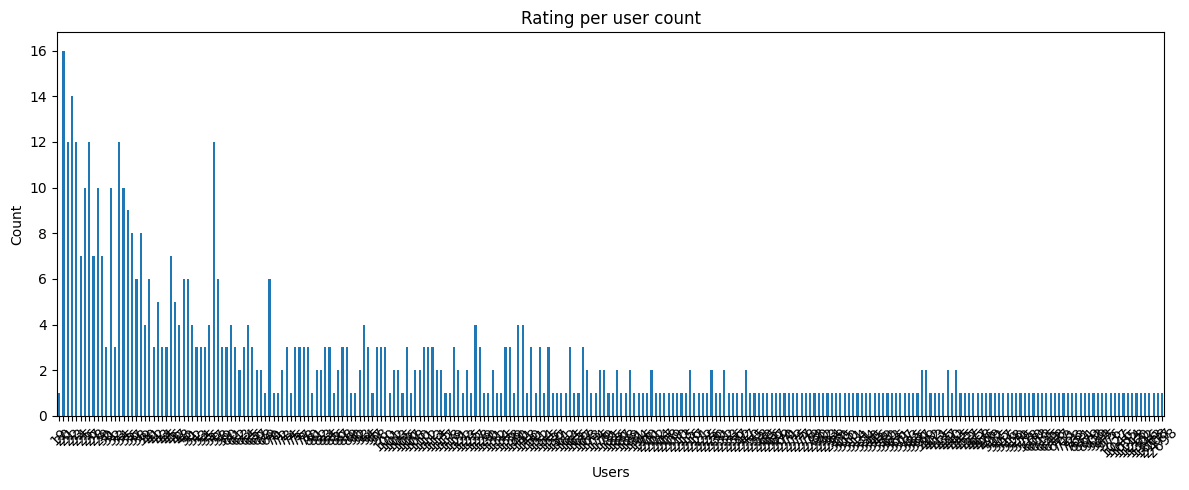

,userId,movieId,rating,timestamp,title,genres,Adventure,Fantasy,Western,Drama,...,Animation,Thriller,War,IMAX,Action,Documentary,Children,Musical,Horror,release_year
0,1,1,4.0,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,1,0,0,...,1,0,0,0,0,0,1,0,0,1995
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
2,1,6,4.0,2000-07-30 18:37:04,Heat (1995),Action|Crime|Thriller,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1995
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1995
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97796,610,166534,4.0,2017-05-03 21:53:22,Split (2017),Drama|Horror|Thriller,0,0,0,1,...,0,1,0,0,0,0,0,0,1,2017
97797,610,168248,5.0,2017-05-03 22:21:31,John Wick: Chapter Two (2017),Action|Crime|Thriller,0,0,0,0,...,0,1,0,0,1,0,0,0,0,2017
97798,610,168250,5.0,2017-05-08 19:50:47,Get Out (2017),Horror,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2017
97799,610,168252,5.0,2017-05-03 21:19:12,Logan (2017),Action|Sci-Fi,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2017


In [11]:
from matplotlib import pyplot as plt

movies_df = pd.read_csv("movies.csv")


num_cols = movies_df.select_dtypes(include=["int64", "float64"]).columns
cat_cols = movies_df.select_dtypes(include=["object"]).columns

rating_df = pd.read_csv("ratings_train.csv")
rating_df['timestamp'] = pd.to_datetime(rating_df['timestamp'], unit='s')

movies_df = movies_df[~movies_df.eq("").any(axis=1)]
rating_df = rating_df[~rating_df.eq("").any(axis=1)]

combined_dataset = rating_df.join(movies_df.set_index('movieId'), on='movieId')

all_categories = set(genre for all_genres in combined_dataset['genres'] for genre in all_genres.split('|'))

for category in all_categories:
    combined_dataset[category] = combined_dataset['genres'].apply(lambda x: 1 if category in x else 0)

combined_dataset['release_year'] = combined_dataset['title'].str.extract(r'\((19[0-9]{2}|20[0-9]{2})\)').astype('Int64')

min_year_per_movie = combined_dataset['timestamp'].dt.year.groupby(combined_dataset['movieId']).transform('min').astype('Int64')

# Fill NaNs in release_year with the smallest year for that movie_id
combined_dataset['release_year'] = combined_dataset['release_year'].fillna(min_year_per_movie)

print("All genres: ", all_categories)
print("Amount of ratings: ", len(combined_dataset['movieId']))
print("Amount of users: ", len(combined_dataset['userId'].unique()))
print("Amount of movies: ", len(combined_dataset['movieId'].unique()))
print("Amount of movies that are rated before release: ", len(combined_dataset[combined_dataset['timestamp'].dt.year < combined_dataset['release_year']]))
print("Interval of dataset: ", combined_dataset["timestamp"].min(), "-", combined_dataset["timestamp"].max())

rating_counts = combined_dataset.groupby('rating')[['rating']].value_counts()
year_counts = combined_dataset.groupby('release_year')[['release_year']].value_counts()
ratings_per_user = combined_dataset.groupby('userId').size()

# Step 2: Count how many users have each rating count
user_rating_distribution = ratings_per_user.value_counts().sort_index()

print("Rating counts: ", rating_counts)
print("Date counts: ", year_counts)
print("Ratings per user counts: ", user_rating_distribution)

# Plot ratings
plt.figure(figsize=(10, 5))
rating_counts.plot(kind='bar')
plt.title('Number of Items by Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot release years
plt.figure(figsize=(12, 5))
year_counts.plot(kind='bar')
plt.title('Number of Items by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot release years
plt.figure(figsize=(12, 5))
user_rating_distribution.plot(kind='bar')
plt.title('Rating per user count')
plt.xlabel('Users')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

combined_dataset

#
# df["curricular_units_1st_sem_grade_rounded"] = df["curricular_units_1st_sem_grade"].round(0)
# df["curricular_units_2nd_sem_grade_rounded"] = df["curricular_units_2nd_sem_grade"].round(0)
#
# df["passing_grade_1st_sem"] = df["curricular_units_1st_sem_grade_rounded"] >= 10
# df["passing_grade_2nd_sem"] = df["curricular_units_2nd_sem_grade_rounded"] >= 10
# df["passed_both_semesters"] = df["passing_grade_1st_sem"] & df["passing_grade_2nd_sem"]

In [4]:
ratings_test_df = pd.read_csv("ratings_test.csv")

print("Percentage of users in the to fill in dataset that is not present in training: ", len(set(ratings_test_df["userId"]) - set(combined_dataset["userId"]))/len(ratings_test_df["userId"]))

Percentage of users in the to fill in dataset that is not present in training:  0.1


In [12]:
import numpy as np

sorted_on_timestamp = combined_dataset.sort_values('timestamp')

# 3. Split into 80% train and 20% test
split_index = int(0.8 * len(sorted_on_timestamp))
df_train = sorted_on_timestamp.iloc[:split_index]
df_test = sorted_on_timestamp.iloc[split_index:]

print("Percentage of users in test dataset that is not present in training when using (20-80 split): ", len(set(df_test["userId"]) - set(df_train["userId"]))/len(set(df_test["userId"])))

reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(combined_dataset[['userId', 'movieId', 'rating']], reader)
df_train, df_test = train_test_split(data, test_size=0.2)
train_users = set([df_train.to_raw_uid(u) for u in df_train.all_users()])
test_users = set([uid for (uid, _, _) in df_test])
print("Percentage of users in test dataset that is not present in training when using (20-80 split): ", len(test_users - train_users)/len(test_users))


sorted_on_userId = combined_dataset.sort_values('userId')
split_index = int(0.8 * len(sorted_on_userId))
df_train = sorted_on_userId.iloc[:split_index]
df_test = sorted_on_userId.iloc[split_index:]


def split_data_train_test(combined_dataset, size_testset = 100, per_cold_start_users = 0.1, per_test_movies = 0.1):
    # Shuffle dataset
    combined_dataset = combined_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

    # Step 1: Select 100 unique users for the test set
    unique_users = combined_dataset['userId'].unique()
    test_user_count = size_testset
    assert test_user_count <= len(unique_users), "Not enough users in dataset to select 100 test users."

    test_users = np.random.choice(unique_users, size=test_user_count, replace=False)

    # Step 2: Select 10% of test users as cold-start (only in test)
    n_cold_users = int(per_cold_start_users * test_user_count)
    cold_users = np.random.choice(test_users, size=n_cold_users, replace=False)
    known_test_users = set(test_users) - set(cold_users)

    # Step 3: Split the data
    cold_user_data = combined_dataset[combined_dataset['userId'].isin(cold_users)]
    non_test_data = combined_dataset[~combined_dataset['userId'].isin(test_users)]
    known_user_data = combined_dataset[combined_dataset['userId'].isin(known_test_users)]

    # Step 4: For known test users, move 10% of their ratings to test set, keep 90% in training
    def split_user_ratings(df):
        df = df.sample(frac=1, random_state=42)
        n_test = max(1, int(per_test_movies * len(df)))
        return df.iloc[n_test:], df.iloc[:n_test]

    train_parts = []
    test_parts = []

    for user_id, group in known_user_data.groupby('userId'):
        train_chunk, test_chunk = split_user_ratings(group)
        train_parts.append(train_chunk)
        test_parts.append(test_chunk)

    # Step 5: Combine everything
    df_train = pd.concat([non_test_data] + train_parts).reset_index(drop=True)
    df_test = pd.concat([cold_user_data] + test_parts).reset_index(drop=True)

    # Final check
    test_users_final = set(df_test['userId'])
    train_users_final = set(df_train['userId'])
    cold_user_pct = len(test_users_final - train_users_final) / len(test_users_final)

    print("Total users in test set:", len(test_users_final))
    print("Cold users (only in test):", len(test_users_final - train_users_final))
    print("Percentage of cold users in test set:", round(cold_user_pct * 100, 2), "%")
    return df_train, df_test


Percentage of users in test dataset that is not present in training when using (20-80 split):  0.7543859649122807
Percentage of users in test dataset that is not present in training when using (20-80 split):  0.0


## Performance testing functions

In [7]:
from collections import defaultdict
from surprise import accuracy

K = 10
RELEVANCE_THRESHOLD = 3.5  # Consider ratings >= 3.5 as relevant

# Build ground truth: relevant items from testset
def get_relevant_items(testset):
    relevant = defaultdict(set)
    for uid, iid, true_r in testset:
        if true_r >= RELEVANCE_THRESHOLD:
            relevant[uid].add(iid)
    return relevant

# Build predictions: top K items per user
def get_top_k(predictions, k=K):
    top_k = defaultdict(list)
    for pred in predictions:
        top_k[pred.uid].append((pred.iid, pred.est))

    # Sort and take top-k
    for uid, user_ratings in top_k.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_k[uid] = [iid for iid, _ in user_ratings[:k]]
    return top_k

# Compute precision and recall
def precision_recall_at_k(predictions, testset, k=K):
    relevant = get_relevant_items(testset)
    top_k_preds = get_top_k(predictions, k)

    precisions = []
    recalls = []

    for uid in top_k_preds:
        pred_set = set(top_k_preds[uid])
        true_set = relevant.get(uid, set())

        if not true_set:
            continue  # Skip users with no relevant items

        hits = pred_set & true_set
        precisions.append(len(hits) / k)
        recalls.append(len(hits) / len(true_set))

    precision = sum(precisions) / len(precisions)
    recall = sum(recalls) / len(recalls)

    return precision, recall



## Building Recommender Models and Evaluation

### model 1 SVD (matrix)

In [165]:
from surprise import accuracy

# A reader is still needed but only the rating_scale param is required.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(combined_dataset[["userId", "movieId", "rating"]], reader)


algo = surprise.SVD()
algo.fit(trainset)

predictions = algo.test(testset)


 ### Model 2

In [22]:
from collections import defaultdict
import pandas as pd
from surprise import Dataset, Reader, KNNWithMeans

def run_model(algo, trainig_df, test_df, full_df):
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(trainig_df[["userId", "movieId", "rating"]], reader)
    trainset = data.build_full_trainset()

    algo.fit(trainset)
    # Get all movies and build user history
    all_movie_ids = set(full_df['movieId'].unique())
    user_rated = full_df.groupby('userId')['movieId'].apply(set).to_dict()

    # Step 1: Build one big testset for all users
    testset = []
    user_unrated_map = defaultdict(list)

    for user_id in test_df['userId'].unique():
        rated = user_rated.get(user_id, set())
        unrated = all_movie_ids - rated
        assert len(unrated) != 0, "No unrated movies for user {}".format(user_id)
        for movie_id in unrated:
            testset.append((user_id, movie_id, 0))
            user_unrated_map[user_id].append(movie_id)

    # Step 2: Predict once in batch
    predictions = algo.test(testset)

    # Step 3: Group predictions by user and extract top 10
    user_pred_map = defaultdict(list)

    for pred in predictions:
        user_pred_map[pred.uid].append((pred.iid, pred.est))

    # Step 4: Extract top 10 for each user
    top_n_recs = []

    for user_id, pred_list in user_pred_map.items():
        top_10 = sorted(pred_list, key=lambda x: x[1], reverse=True)[:10]
        top_n_recs.append([user_id] + [item[0] for item in top_10])

    # Step 5: Save to CSV
    rec_df = pd.DataFrame(top_n_recs, columns=["user_id"] + ["recommendation" + str(item + 1) for item in range(0,10)])

    print("Fast batch recommendations saved to 'user_recommendations.csv'")

    return rec_df


df_train, df_test = split_data_train_test(combined_dataset, 100, 0.1,0.1)

print("cold_start_users:", set(df_test["userId"]) - set(df_train["userId"]))

print("df_Test userId count", len(df_test["userId"].unique()))

algo = KNNWithMeans(sim_options={'name': 'cosine', 'user_based': True})
algo = surprise.SVD()
run_model(algo, df_train, df_test, combined_dataset)
#
# precision, recall = precision_recall_at_k(predictions, testset)
# print(f"Precision@{K}: {precision:.4f}")
# print(f"Recall@{K}: {recall:.4f}")

Total users in test set: 100
Cold users (only in test): 10
Percentage of cold users in test set: 10.0 %
cold_start_users: {103, 461, 334, 111, 398, 371, 596, 316, 342, 540}
df_Test userId count 100
Fast batch recommendations saved to 'user_recommendations.csv'


,user_id,recommendation1,recommendation2,recommendation3,recommendation4,recommendation5,recommendation6,recommendation7,recommendation8,recommendation9,recommendation10
0,334,1204,898,1276,50,1104,1197,858,1208,912,1225
1,596,318,1204,750,898,1276,1104,1208,912,1225,1213
2,103,1204,898,1276,1104,1225,1261,3275,933,904,246
3,111,1204,750,898,1276,50,1104,858,1208,912,1225
4,342,318,1204,750,898,1276,50,1104,1197,858,1208
...,...,...,...,...,...,...,...,...,...,...,...
95,592,260,1196,1210,2959,3083,1270,1945,246,1089,54001
96,597,296,2067,2571,1262,750,924,1178,3213,5618,608
97,599,527,1203,1288,2324,954,44555,1235,92535,1303,1276
98,602,898,750,1197,1196,1208,2858,6016,1204,7153,1073


In [ ]:


# Surprise setup
run_model(combined_dataset, ratings_test, combined_dataset)

In [ ]:
#Fill dataset
ratings_test = pd.read_csv('ratings_test.csv')

# Surprise setup
run_model(combined_dataset, ratings_test, combined_dataset)

### Model 3 Matrix factorisation


In [37]:
# A reader is still needed but only the rating_scale param is required.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(combined_dataset[["userId", "movieId", "rating"]], reader)
trainset, testset = train_test_split(data, test_size=0.25)
